In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [110]:
optimal_k=15

In [111]:
# データ読み込み（npz優先、CSVフォールバック）
import os

cluster_0_indices = None

if os.path.exists('cluster_0_data.npz'):
    data = np.load('cluster_0_data.npz')
    cluster_0_latent = data['latent']
    cluster_0_k_values = data['k']
    cluster_0_f_values = data['f']
    if 'indices' in data:
        cluster_0_indices = data['indices']
else:
    cluster_0_latent = np.loadtxt('cluster_0_latent.csv', delimiter=',')
    cluster_0_k_values = np.loadtxt('cluster_0_k_values.csv', delimiter=',')
    cluster_0_f_values = np.loadtxt('cluster_0_f_values.csv', delimiter=',')

# バリデーション
cluster_0_latent = np.asarray(cluster_0_latent, dtype=float)
cluster_0_k_values = np.asarray(cluster_0_k_values, dtype=float).reshape(-1)
cluster_0_f_values = np.asarray(cluster_0_f_values, dtype=float).reshape(-1)

assert cluster_0_latent.ndim == 2, f"latentの次元が不正です: {cluster_0_latent.shape}"
n_samples = cluster_0_latent.shape[0]
assert cluster_0_k_values.shape[0] == n_samples, "kのサンプル数がlatentと一致しません"
assert cluster_0_f_values.shape[0] == n_samples, "fのサンプル数がlatentと一致しません"

# indices フォールバック（npzに含まれない場合）
if cluster_0_indices is None:
    cluster_0_indices = np.arange(n_samples)


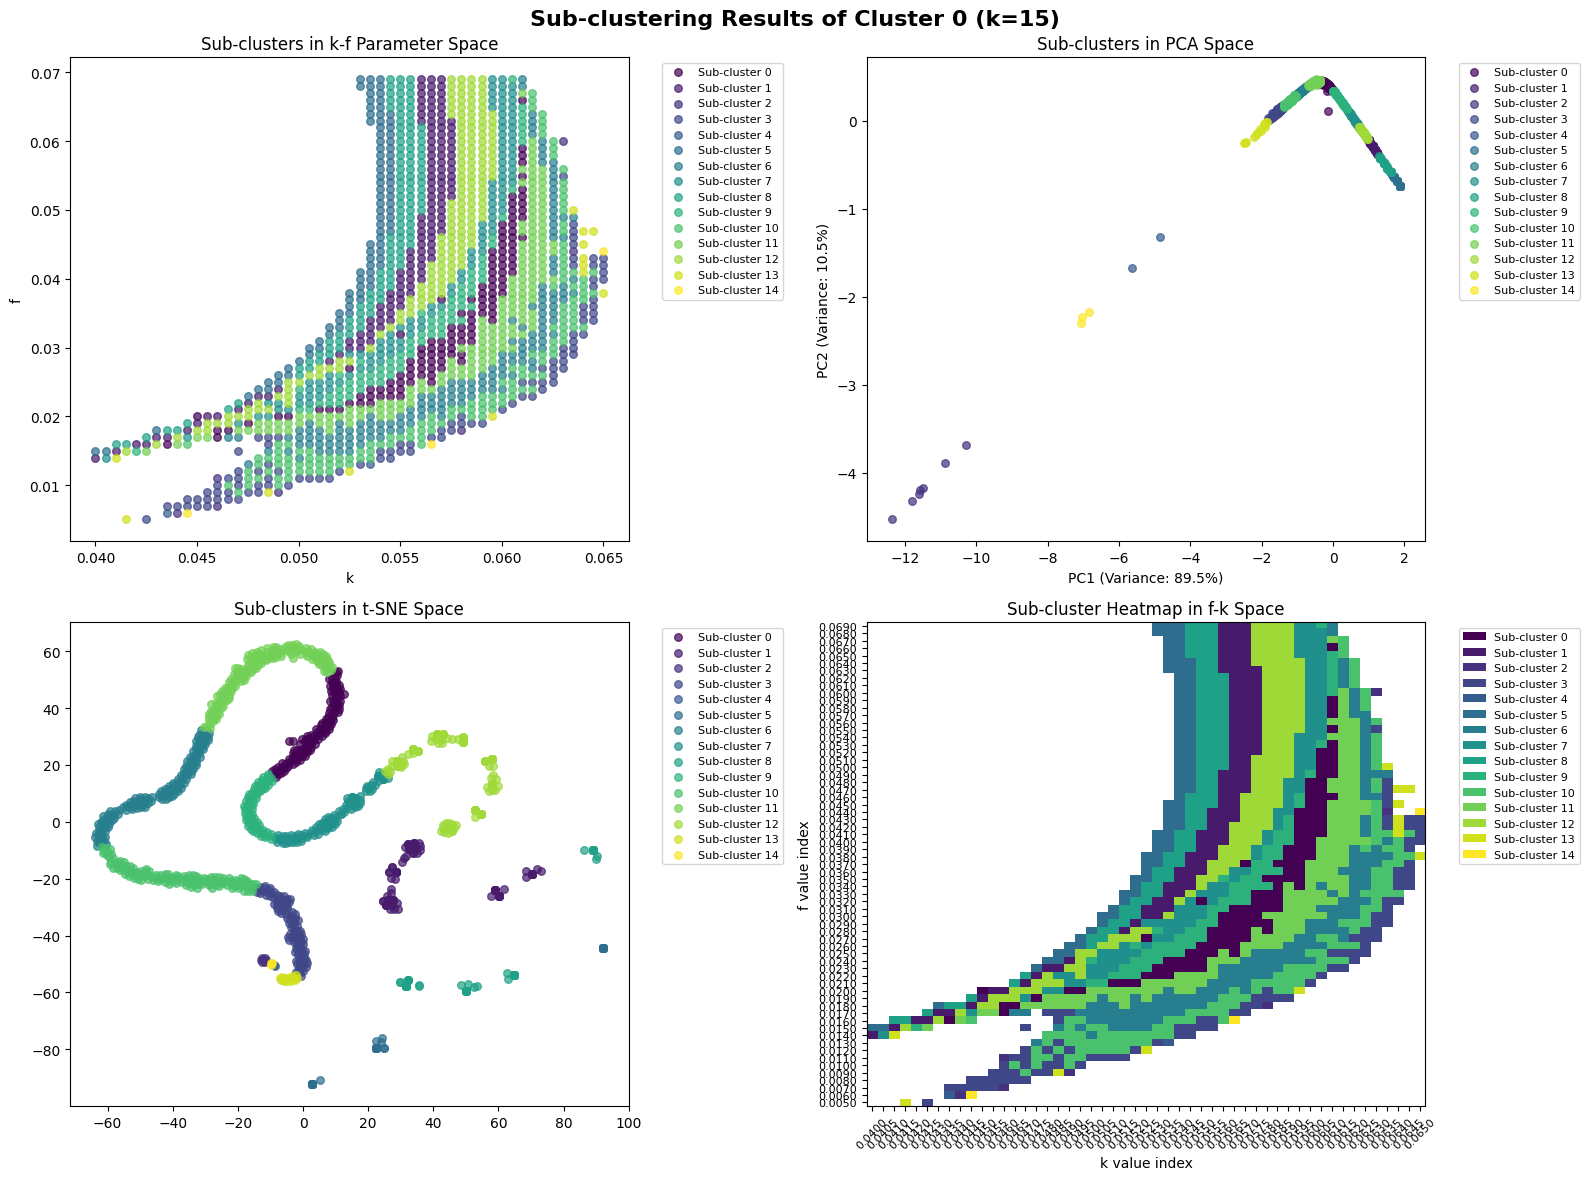

In [112]:
# 最適なクラスター数でサブクラスタリングを実行
kmeans_sub = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
sub_cluster_labels = kmeans_sub.fit_predict(cluster_0_latent)

# サブクラスターの可視化
# PCAとt-SNEを使用して次元削減
pca_sub = PCA(n_components=2, random_state=42)
pca_sub_result = pca_sub.fit_transform(cluster_0_latent)

tsne_sub = TSNE(n_components=2, random_state=42, perplexity=min(30, len(cluster_0_latent)//4))
tsne_sub_result = tsne_sub.fit_transform(cluster_0_latent)

# サブクラスターの可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Sub-clustering Results of Cluster 0 (k={optimal_k})', fontsize=16, fontweight='bold')

# Create colors for each sub-cluster
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))

# f-k space sub-clusters
for i in range(optimal_k):
    mask = sub_cluster_labels == i
    axes[0, 0].scatter(cluster_0_k_values[mask], cluster_0_f_values[mask], 
                      c=[colors[i]], alpha=0.7, s=30, label=f'Sub-cluster {i}')
axes[0, 0].set_xlabel('k')
axes[0, 0].set_ylabel('f')
axes[0, 0].set_title('Sub-clusters in k-f Parameter Space')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# PCA space sub-clusters
for i in range(optimal_k):
    mask = sub_cluster_labels == i
    axes[0, 1].scatter(pca_sub_result[mask, 0], pca_sub_result[mask, 1], 
                      c=[colors[i]], alpha=0.7, s=30, label=f'Sub-cluster {i}')
axes[0, 1].set_title('Sub-clusters in PCA Space')
axes[0, 1].set_xlabel(f'PC1 (Variance: {pca_sub.explained_variance_ratio_[0]:.1%})')
axes[0, 1].set_ylabel(f'PC2 (Variance: {pca_sub.explained_variance_ratio_[1]:.1%})')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# t-SNE space sub-clusters
for i in range(optimal_k):
    mask = sub_cluster_labels == i
    axes[1, 0].scatter(tsne_sub_result[mask, 0], tsne_sub_result[mask, 1], 
                      c=[colors[i]], alpha=0.7, s=30, label=f'Sub-cluster {i}')
axes[1, 0].set_title('Sub-clusters in t-SNE Space')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Sub-cluster heatmap in f-k space
f_unique_sub = np.unique(cluster_0_f_values)
k_unique_sub = np.unique(cluster_0_k_values)
heatmap_sub = np.full((len(f_unique_sub), len(k_unique_sub)), np.nan)

for i, (f, k, label) in enumerate(zip(cluster_0_f_values, cluster_0_k_values, sub_cluster_labels)):
    f_idx = np.where(f_unique_sub == f)[0][0]
    k_idx = np.where(k_unique_sub == k)[0][0]
    heatmap_sub[f_idx, k_idx] = label

im = axes[1, 1].imshow(heatmap_sub, cmap='viridis', aspect='auto', origin='lower', 
                      vmin=0, vmax=optimal_k-1)
axes[1, 1].set_title('Sub-cluster Heatmap in f-k Space')
axes[1, 1].set_xlabel('k value index')
axes[1, 1].set_ylabel('f value index')

# Set axis labels to actual values
axes[1, 1].set_xticks(range(len(k_unique_sub)))
axes[1, 1].set_yticks(range(len(f_unique_sub)))
axes[1, 1].set_xticklabels([f'{k:.4f}' for k in k_unique_sub], rotation=45, fontsize=8)
axes[1, 1].set_yticklabels([f'{f:.4f}' for f in f_unique_sub], fontsize=8)

# Create custom legend for heatmap
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], label=f'Sub-cluster {i}') 
                  for i in range(optimal_k)]
axes[1, 1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()


In [113]:
# サブクラスターの詳細統計情報を表示
print("Sub-cluster Detailed Statistics:")
print("=" * 60)

for i in range(optimal_k):
    mask = sub_cluster_labels == i
    count = np.sum(mask)
    f_mean = cluster_0_f_values[mask].mean()
    f_std = cluster_0_f_values[mask].std()
    k_mean = cluster_0_k_values[mask].mean()
    k_std = cluster_0_k_values[mask].std()
    
    print(f"\nSub-cluster {i}:")
    print(f"  Sample count: {count}")
    print(f"  Percentage: {count/len(cluster_0_latent)*100:.1f}%")
    print(f"  f-value: {f_mean:.4f} ± {f_std:.4f}")
    print(f"  k-value: {k_mean:.4f} ± {k_std:.4f}")
    print(f"  f-range: [{cluster_0_f_values[mask].min():.4f}, {cluster_0_f_values[mask].max():.4f}]")
    print(f"  k-range: [{cluster_0_k_values[mask].min():.4f}, {cluster_0_k_values[mask].max():.4f}]")


Sub-cluster Detailed Statistics:

Sub-cluster 0:
  Sample count: 117
  Percentage: 8.7%
  f-value: 0.0345 ± 0.0107
  k-value: 0.0571 ± 0.0038
  f-range: [0.0160, 0.0660]
  k-range: [0.0435, 0.0610]

Sub-cluster 1:
  Sample count: 127
  Percentage: 9.4%
  f-value: 0.0465 ± 0.0150
  k-value: 0.0546 ± 0.0039
  f-range: [0.0140, 0.0690]
  k-range: [0.0400, 0.0575]

Sub-cluster 2:
  Sample count: 7
  Percentage: 0.5%
  f-value: 0.0221 ± 0.0197
  k-value: 0.0528 ± 0.0078
  f-range: [0.0060, 0.0600]
  k-range: [0.0440, 0.0635]

Sub-cluster 3:
  Sample count: 101
  Percentage: 7.5%
  f-value: 0.0217 ± 0.0124
  k-value: 0.0558 ± 0.0075
  f-range: [0.0050, 0.0550]
  k-range: [0.0425, 0.0650]

Sub-cluster 4:
  Sample count: 2
  Percentage: 0.1%
  f-value: 0.0095 ± 0.0035
  k-value: 0.0485 ± 0.0050
  f-range: [0.0060, 0.0130]
  k-range: [0.0435, 0.0535]

Sub-cluster 5:
  Sample count: 92
  Percentage: 6.8%
  f-value: 0.0473 ± 0.0145
  k-value: 0.0527 ± 0.0027
  f-range: [0.0150, 0.0690]
  k-range:

サブクラスターの詳細分析:

サブクラスター 0:
  サンプル数: 117
  全体に占める割合: 8.7%
  f値範囲: 0.0160 - 0.0660
  k値範囲: 0.0435 - 0.0610
  元データでのインデックス例: [123, 132, 142, 151, 162]

サブクラスター 1:
  サンプル数: 127
  全体に占める割合: 9.4%
  f値範囲: 0.0140 - 0.0690
  k値範囲: 0.0400 - 0.0575
  元データでのインデックス例: [50, 105, 112, 122, 136]

サブクラスター 2:
  サンプル数: 7
  全体に占める割合: 0.5%
  f値範囲: 0.0060 - 0.0600
  k値範囲: 0.0440 - 0.0635
  元データでのインデックス例: [744, 1358, 1660, 2393, 3372]

サブクラスター 3:
  サンプル数: 101
  全体に占める割合: 7.5%
  f値範囲: 0.0050 - 0.0550
  k値範囲: 0.0425 - 0.0650
  元データでのインデックス例: [10, 20, 24, 33, 38]

サブクラスター 4:
  サンプル数: 2
  全体に占める割合: 0.1%
  f値範囲: 0.0060 - 0.0130
  k値範囲: 0.0435 - 0.0535
  元データでのインデックス例: [2269, 3643]

サブクラスター 5:
  サンプル数: 92
  全体に占める割合: 6.8%
  f値範囲: 0.0150 - 0.0690
  k値範囲: 0.0400 - 0.0545
  元データでのインデックス例: [18, 44, 53, 63, 87]

サブクラスター 6:
  サンプル数: 149
  全体に占める割合: 11.0%
  f値範囲: 0.0130 - 0.0690
  k値範囲: 0.0465 - 0.0635
  元データでのインデックス例: [3, 203, 205, 215, 225]

サブクラスター 7:
  サンプル数: 108
  全体に占める割合: 8.0%
  f値範囲: 0.0140 - 0.0690
  k値範囲: 0.0405 

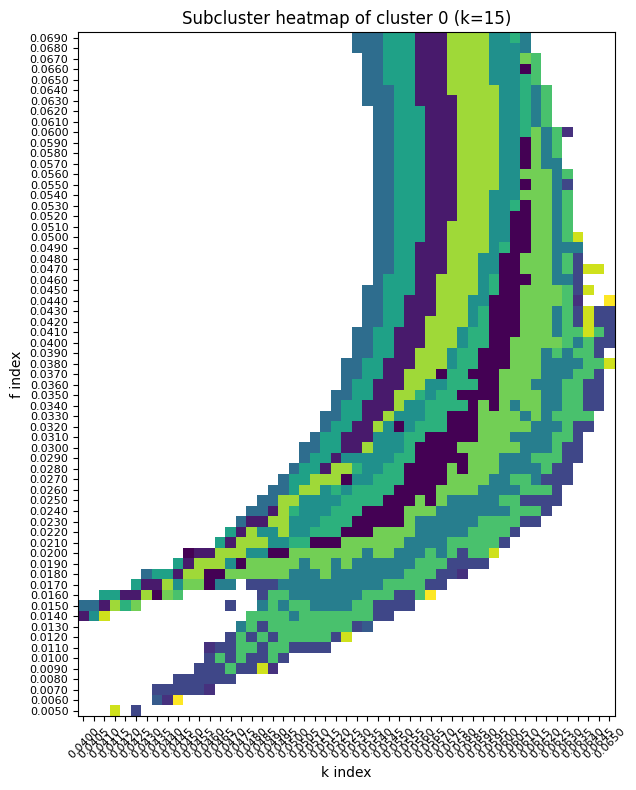

In [114]:
# サブクラスターの詳細分析とヒートマップ
print("サブクラスターの詳細分析:")
print("=" * 50)

# 各サブクラスターの特徴を分析
for i in range(optimal_k):
    mask = sub_cluster_labels == i
    indices = cluster_0_indices[mask]  # 元のデータセットでのインデックス
    
    print(f"\nサブクラスター {i}:")
    print(f"  サンプル数: {np.sum(mask)}")
    print(f"  全体に占める割合: {np.sum(mask)/len(cluster_0_latent)*100:.1f}%")
    print(f"  f値範囲: {cluster_0_f_values[mask].min():.4f} - {cluster_0_f_values[mask].max():.4f}")
    print(f"  k値範囲: {cluster_0_k_values[mask].min():.4f} - {cluster_0_k_values[mask].max():.4f}")
    print(f"  元データでのインデックス例: {indices[:5].tolist()}")

# サブクラスターのヒートマップを作成
plt.figure(figsize=(12, 8))

# f-k空間でのサブクラスターヒートマップ
f_unique_sub = np.unique(cluster_0_f_values)
k_unique_sub = np.unique(cluster_0_k_values)
heatmap_sub = np.full((len(f_unique_sub), len(k_unique_sub)), np.nan)

for i, (f, k, label) in enumerate(zip(cluster_0_f_values, cluster_0_k_values, sub_cluster_labels)):
    f_idx = np.where(f_unique_sub == f)[0][0]
    k_idx = np.where(k_unique_sub == k)[0][0]
    heatmap_sub[f_idx, k_idx] = label

im = plt.imshow(heatmap_sub, cmap='viridis', aspect='auto', origin='lower', 
                vmin=0, vmax=optimal_k-1)
plt.title(f'Subcluster heatmap of cluster 0 (k={optimal_k})')
plt.xlabel('k index')
plt.ylabel('f index')
# アスペクト比を1に設定
plt.gca().set_aspect('equal')

# 軸ラベルを実際の値に設定
plt.xticks(range(len(k_unique_sub)), [f'{k:.4f}' for k in k_unique_sub], rotation=45, fontsize=8)
plt.yticks(range(len(f_unique_sub)), [f'{f:.4f}' for f in f_unique_sub], fontsize=8)

#plt.colorbar(im, label='サブクラスターID')
plt.tight_layout()
plt.show()


In [115]:
def plot_implicit_zero_fk(
    G, klim, flim, ax=None, levels=(0.0,), n=400,
    color='crimson', linewidth=2, label=None, mask_complex=True, tol=1e-10
):
    """
    G(f, k)=0 の等高線を描画する。
    - G: callable(f, k) -> array-like（複素数可）
    - klim, flim: (kmin, kmax), (fmin, fmax)
    - n: グリッド密度
    横軸=k, 縦軸=f で描画
    """
    if ax is None:
        ax = plt.gca()

    k = np.linspace(klim[0], klim[1], n)
    f = np.linspace(flim[0], flim[1], n)
    K, F = np.meshgrid(k, f)

    Z = G(F, K)  # G(f, k) を評価（Fが縦軸、Kが横軸）

    if np.iscomplexobj(Z) and mask_complex:
        mask_real = np.abs(np.imag(Z)) < tol
        Z = np.where(mask_real, np.real(Z), np.nan)
    else:
        Z = np.asarray(Z, dtype=float)

    zmin, zmax = np.nanmin(Z), np.nanmax(Z)
    if not (zmin <= 0.0 <= zmax):
        print("Warning: no zero crossing in the given window.")
        return None

    cs = ax.contour(K, F, Z, levels=levels, colors=color, linewidths=linewidth)
    if label and cs.collections:
        cs.collections[0].set_label(label)
        ax.legend()

    ax.set_xlabel('k')
    ax.set_ylabel('f')
    ax.set_box_aspect(1)
    return cs

/var/folders/z3/qtwkwxv15gq8vr6m4nbgff_w0000gq/T/ipykernel_35208/268775312.py:17: RuntimeWarning: invalid value encountered in sqrt
  return 4*k - (f + np.sqrt(f*(f-4*(f+k)**2)))**2 / ((f + k)**2)


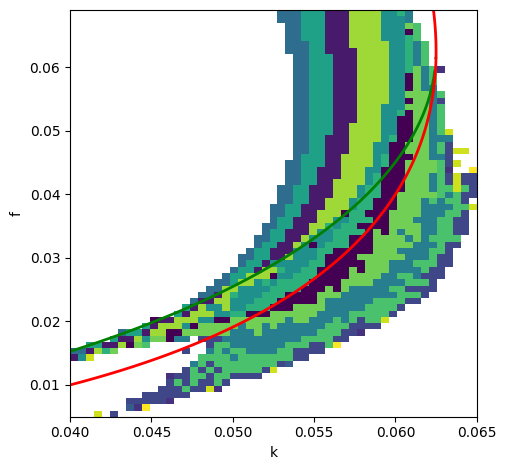

In [116]:
fmin, fmax = float(np.min(f_unique_sub)), float(np.max(f_unique_sub))
kmin, kmax = float(np.min(k_unique_sub)), float(np.max(k_unique_sub))

plt.imshow(
    heatmap_sub,
    cmap='viridis', aspect='auto', origin='lower',
    vmin=0, vmax=optimal_k-1,
    extent=[kmin, kmax, fmin, fmax]  # ←追加
)
plt.gca().set_box_aspect(1) 
plt.tight_layout()
#plt.show()


def G_Hopf(f, k):
    # 解析式を記入（例）
    return 4*k - (f + np.sqrt(f*(f-4*(f+k)**2)))**2 / ((f + k)**2)

plot_implicit_zero_fk(G_Hopf, (kmin, kmax), (fmin, fmax), color='green')


def G_NumSoln(f, k):
    # 解析式を記入（例）
    return f - 4*f**2 - 8*f*k - 4*k**2

plot_implicit_zero_fk(G_NumSoln, (kmin, kmax), (fmin, fmax), color='red')


plt.tight_layout()
plt.show()

In [117]:
def plot_final_heatmap_for_k(optimal_k: int, ax=None):
    # KMeans sub-clustering
    kmeans_sub = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    sub_cluster_labels = kmeans_sub.fit_predict(cluster_0_latent)

    # Build heatmap for f-k space
    f_unique_sub = np.unique(cluster_0_f_values)
    k_unique_sub = np.unique(cluster_0_k_values)
    heatmap_sub = np.full((len(f_unique_sub), len(k_unique_sub)), np.nan)

    for f, k, label in zip(cluster_0_f_values, cluster_0_k_values, sub_cluster_labels):
        f_idx = np.where(f_unique_sub == f)[0][0]
        k_idx = np.where(k_unique_sub == k)[0][0]
        heatmap_sub[f_idx, k_idx] = label

    # determine axes
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        created_fig = True
    else:
        fig = ax.figure

    # compute data extents first for consistent coordinates
    fmin, fmax = float(np.min(f_unique_sub)), float(np.max(f_unique_sub))
    kmin, kmax = float(np.min(k_unique_sub)), float(np.max(k_unique_sub))

    im = ax.imshow(
        heatmap_sub,
        cmap='viridis', aspect='auto', origin='lower',
        vmin=0, vmax=optimal_k-1,
        extent=[kmin, kmax, fmin, fmax]
    )
    ax.set_title(f'k={optimal_k}', fontsize=10)
    ax.set_xlabel('k')
    ax.set_ylabel('f')
    ax.set_box_aspect(1)

    # Axis tick labels to actual values
    ax.set_xlim(kmin, kmax)
    ax.set_ylim(fmin, fmax)
    ax.set_xticks(k_unique_sub)
    ax.set_yticks(f_unique_sub)
    ax.set_xticklabels([f'{k:.4f}' for k in k_unique_sub], rotation=45, fontsize=7)
    ax.set_yticklabels([f'{f:.4f}' for f in f_unique_sub], fontsize=7)

    # Overlay implicit curves G_Hopf and G_NumSoln if available (define defaults if missing)
    try:
        _ = G_Hopf
    except NameError:
        def G_Hopf(f, k):
            f = np.asarray(f, dtype=float)
            k = np.asarray(k, dtype=float)
            rad = f * (f - 4 * (f + k) ** 2)
            # use real sqrt only where rad>=0; elsewhere mark as NaN
            root = np.full_like(rad, np.nan, dtype=float)
            mask = rad >= 0
            root[mask] = np.sqrt(rad[mask])
            denom = (f + k)
            # avoid division by zero
            small = np.abs(denom) < 1e-12
            val = 4 * k - ((f + root) ** 2) / (denom ** 2)
            val[~mask] = np.nan
            val[small] = np.nan
            return val
    try:
        _ = G_NumSoln
    except NameError:
        def G_NumSoln(f, k):
            return f - 4*f**2 - 8*f*k - 4*k**2

    # Draw contours on the same axes
    try:
        plot_implicit_zero_fk(G_Hopf, (kmin, kmax), (fmin, fmax), ax=ax, color='green', label='G_Hopf')
    except Exception:
        pass
    try:
        plot_implicit_zero_fk(G_NumSoln, (kmin, kmax), (fmin, fmax), ax=ax, color='red', label='G_NumSoln')
    except Exception:
        pass

    if created_fig:
        plt.tight_layout()
        plt.show()
    return fig


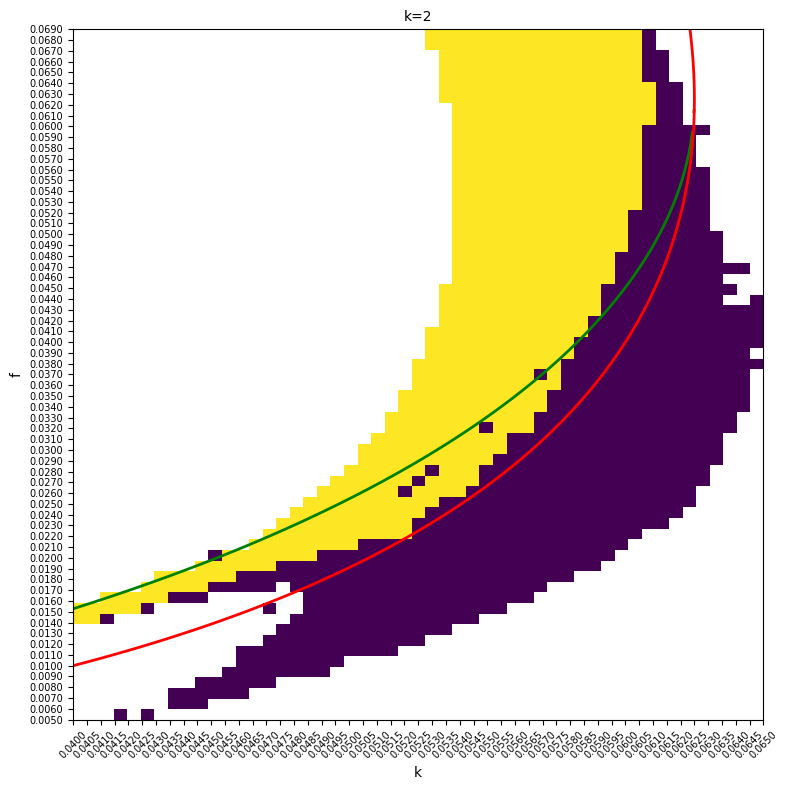

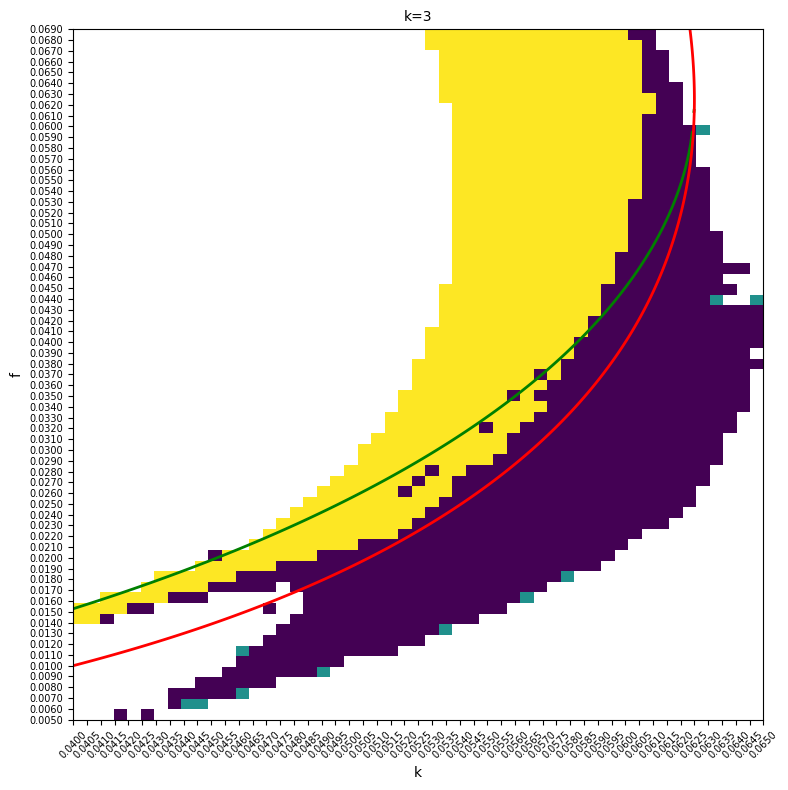

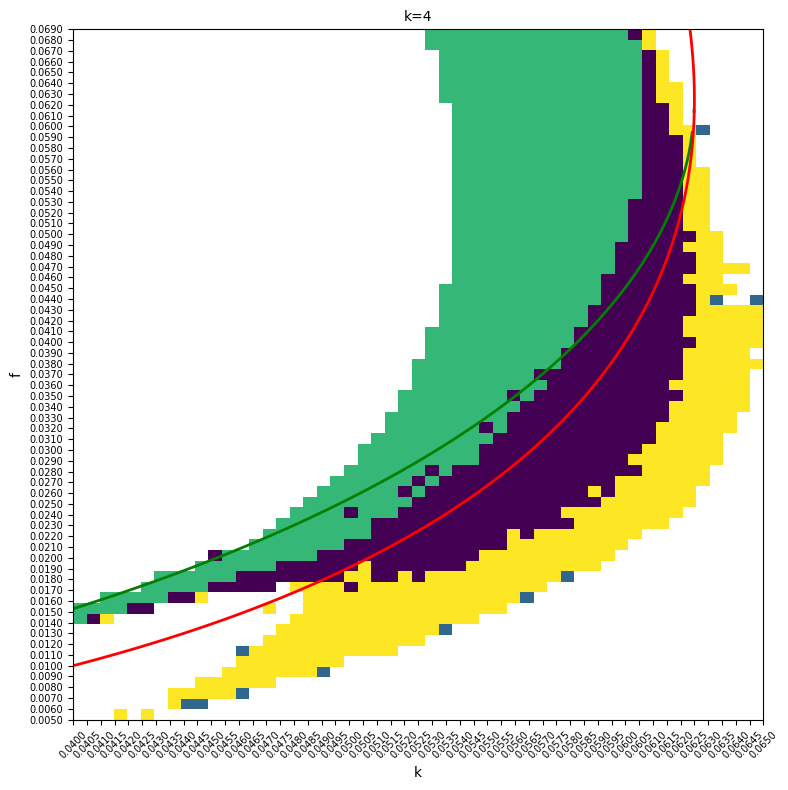

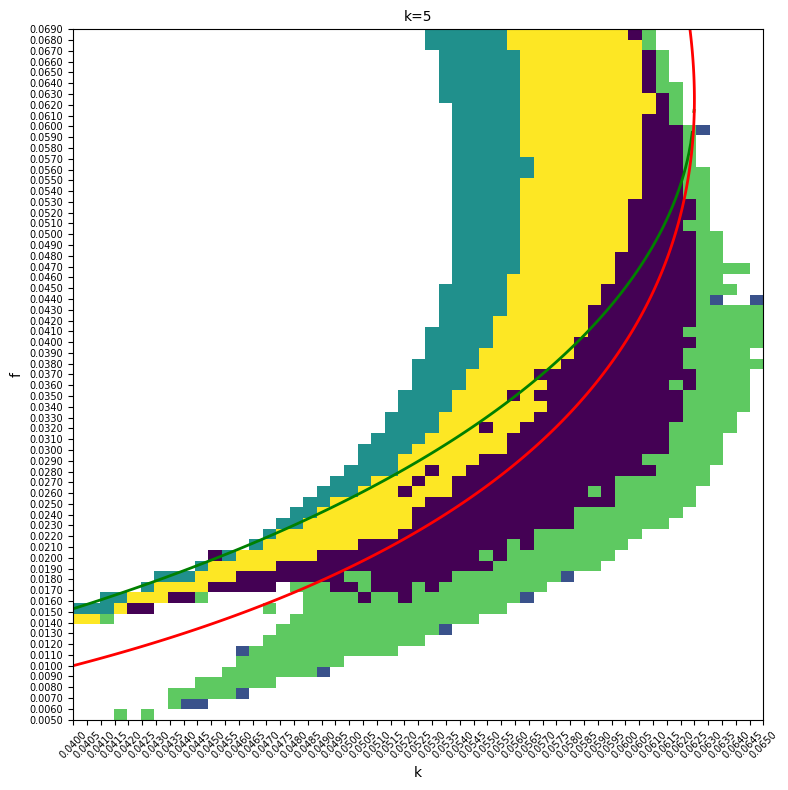

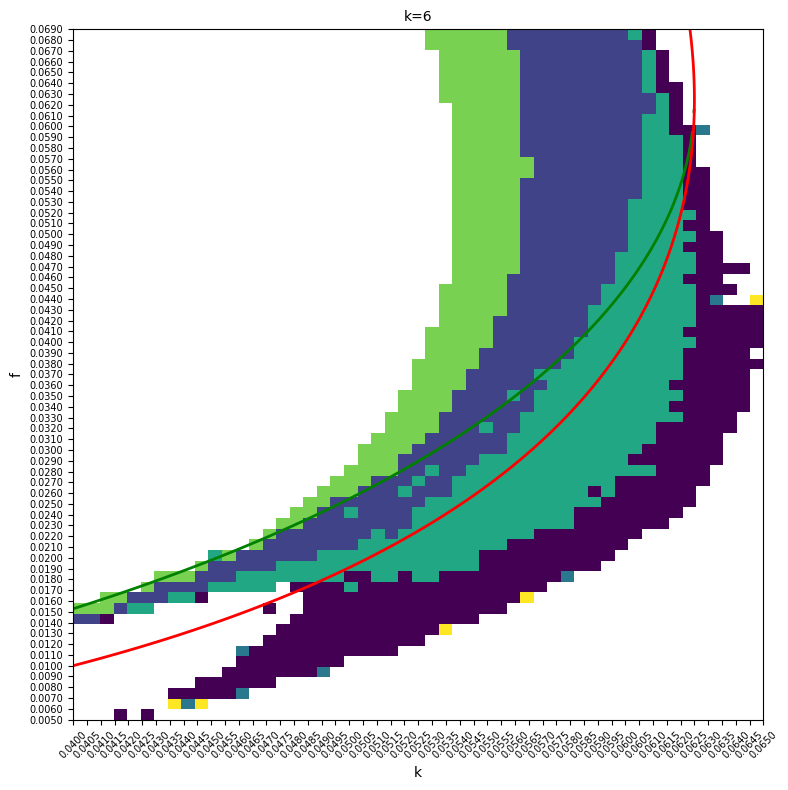

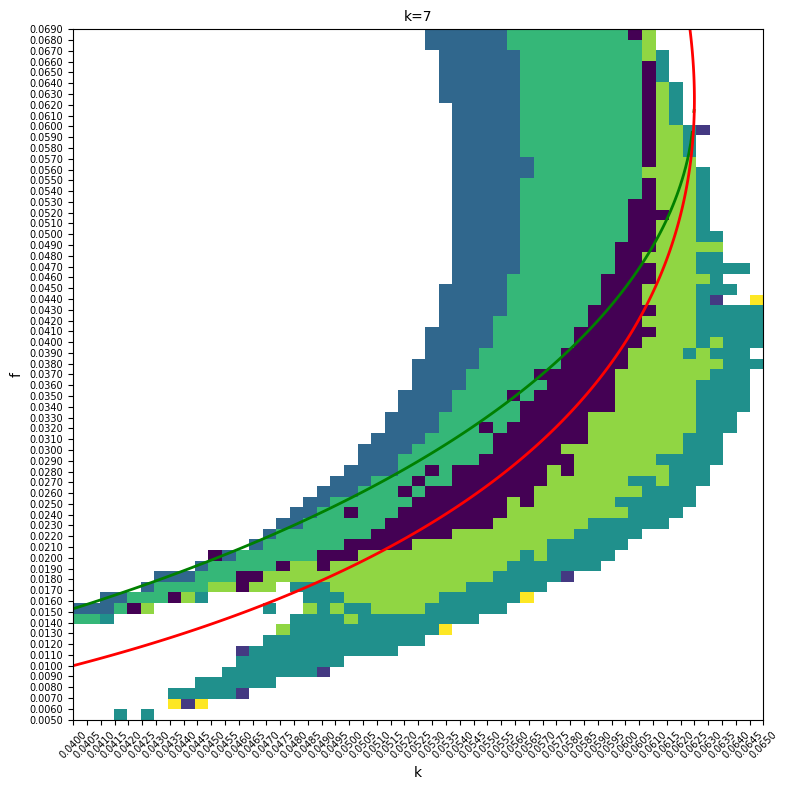

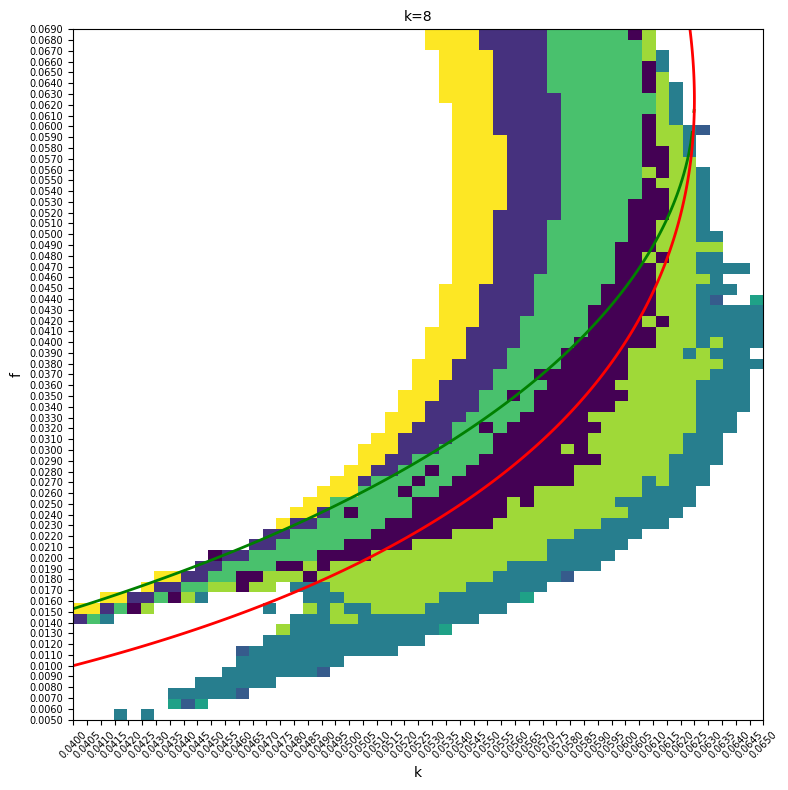

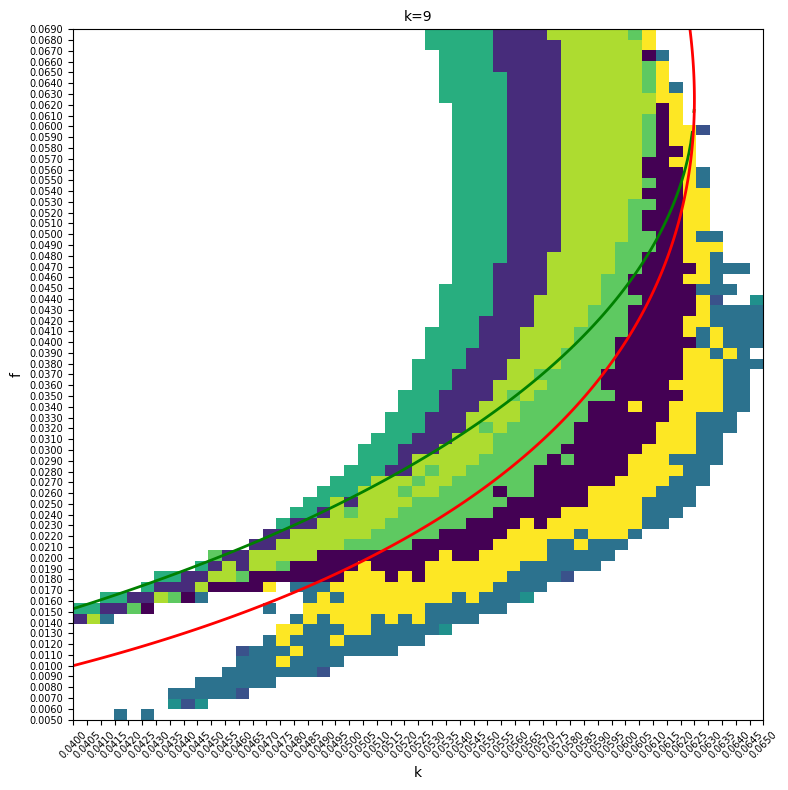

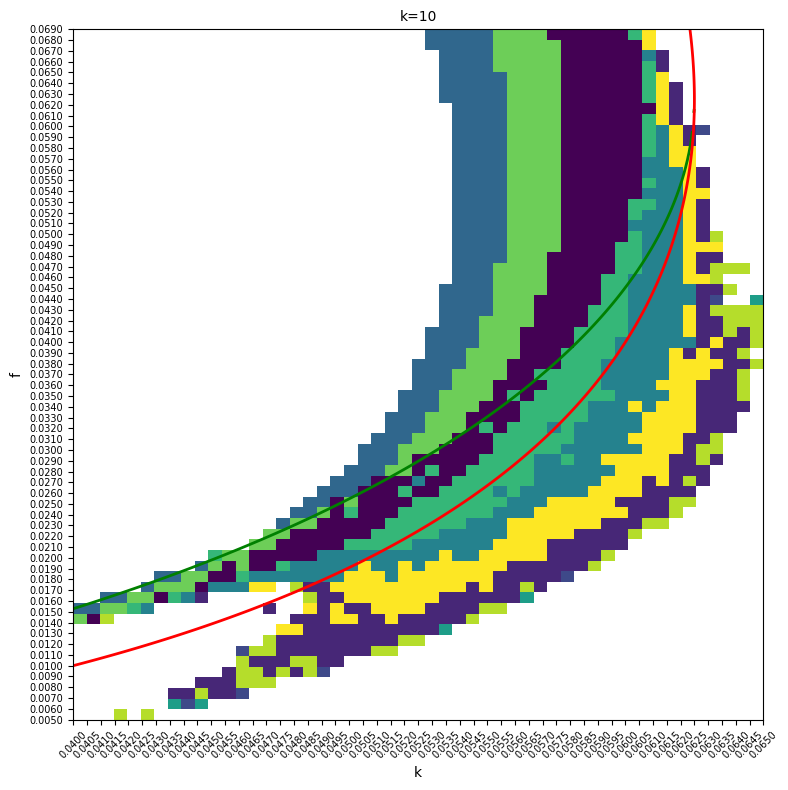

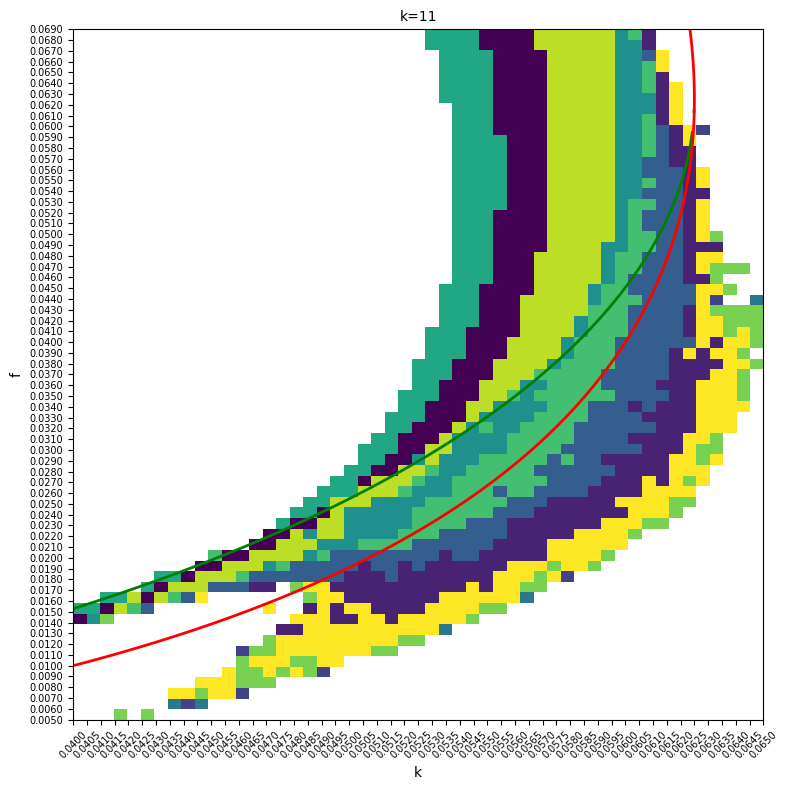

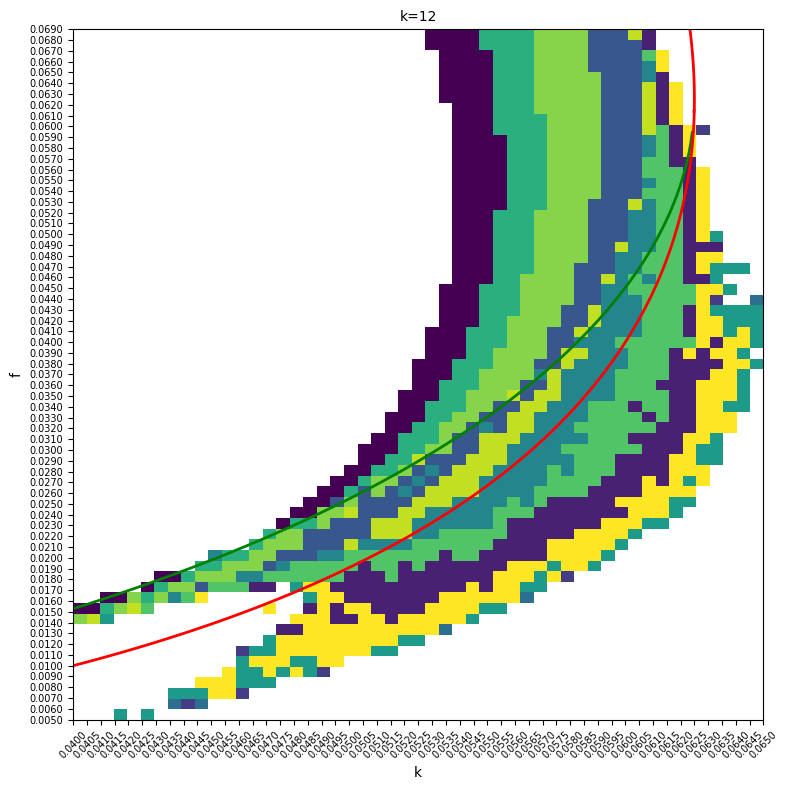

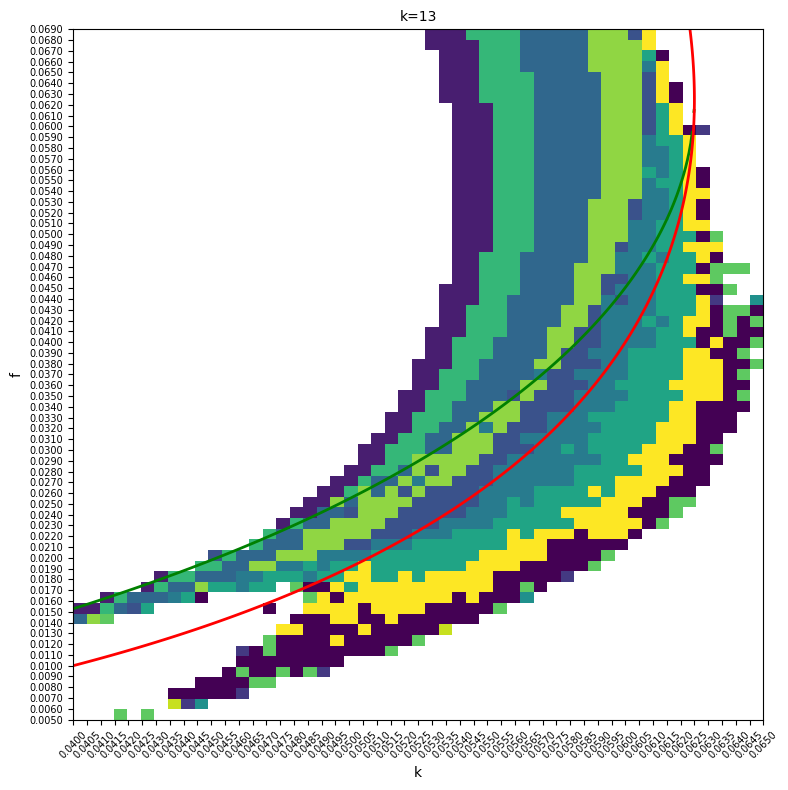

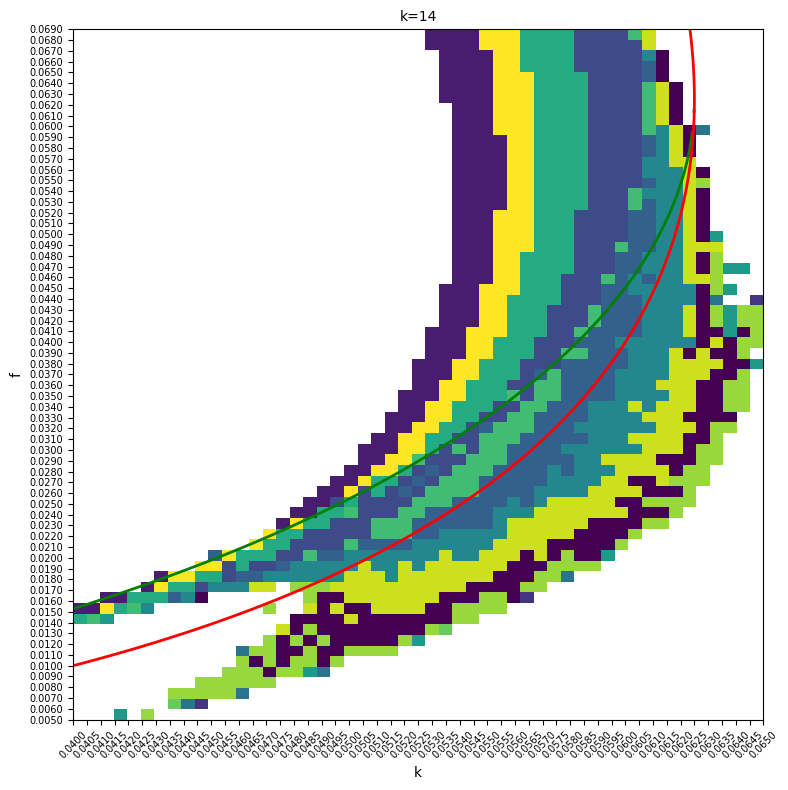

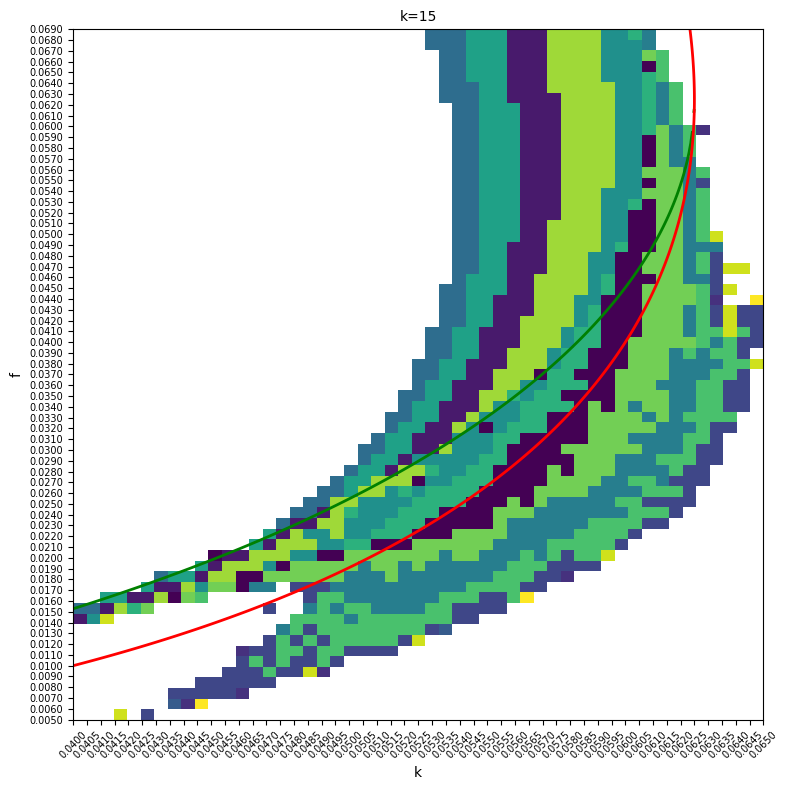

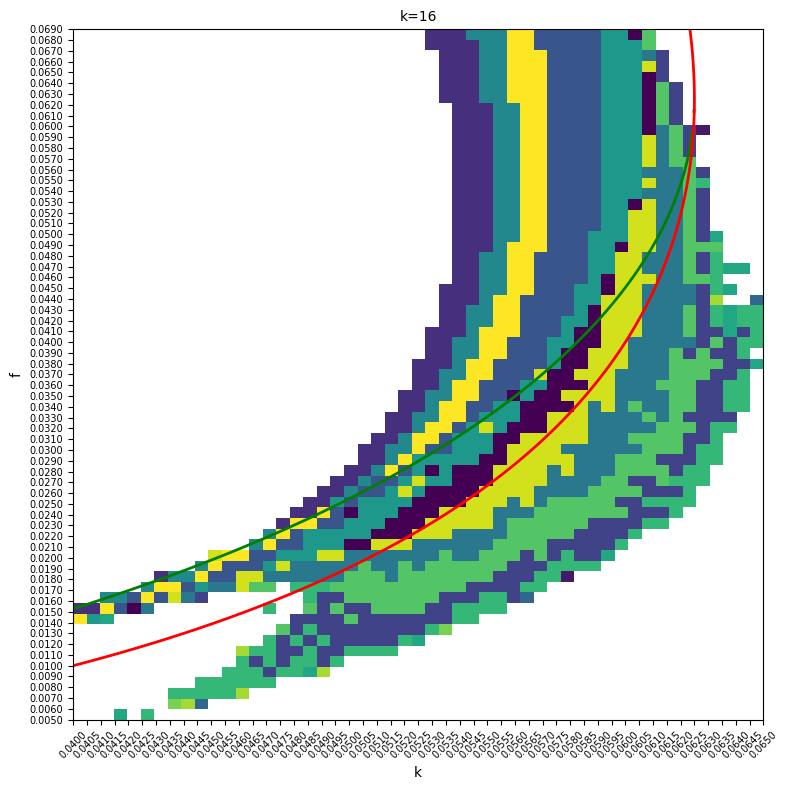

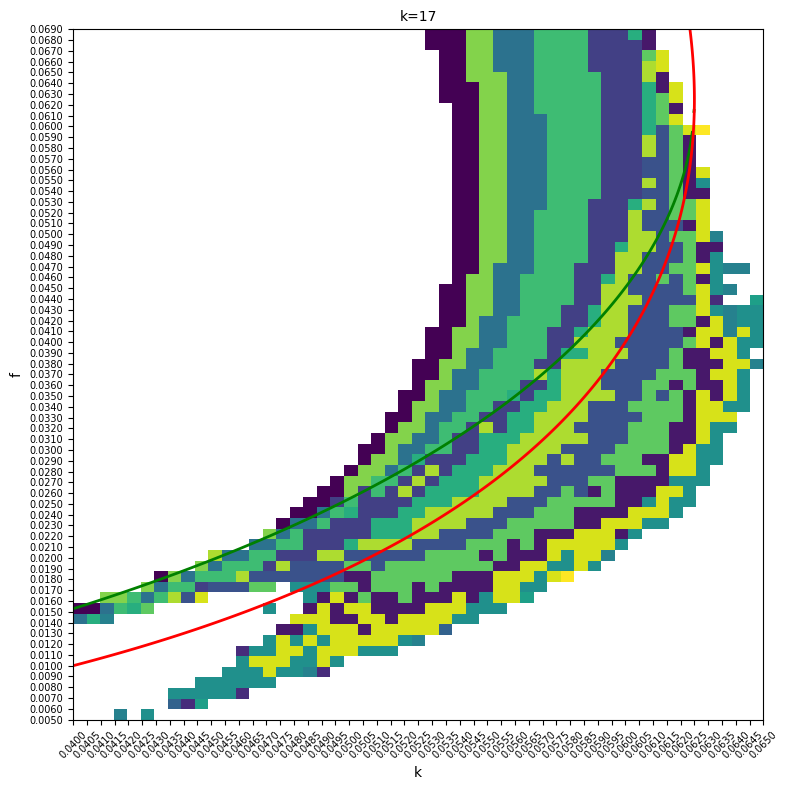

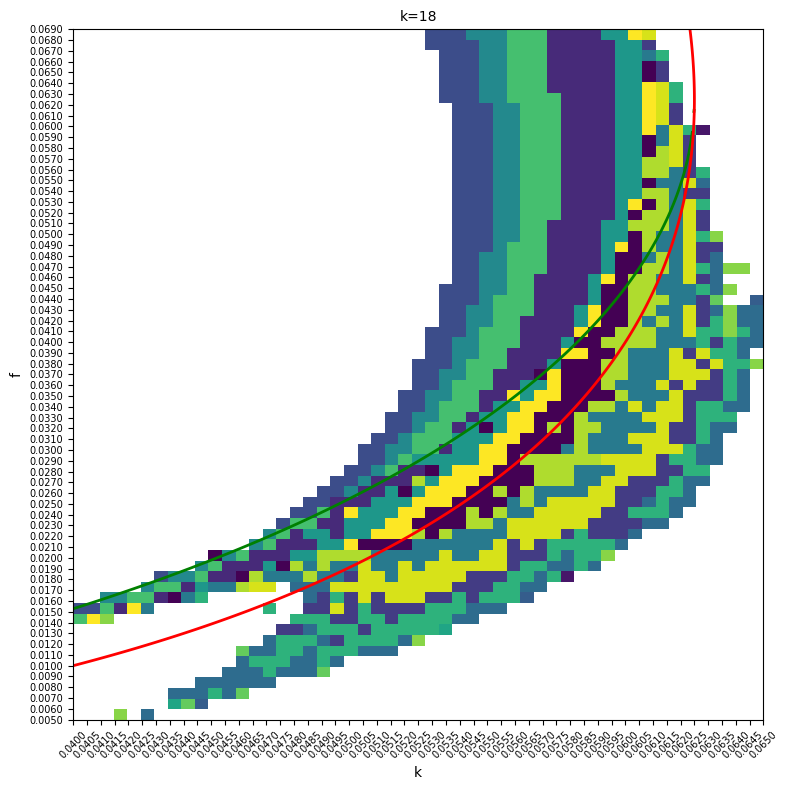

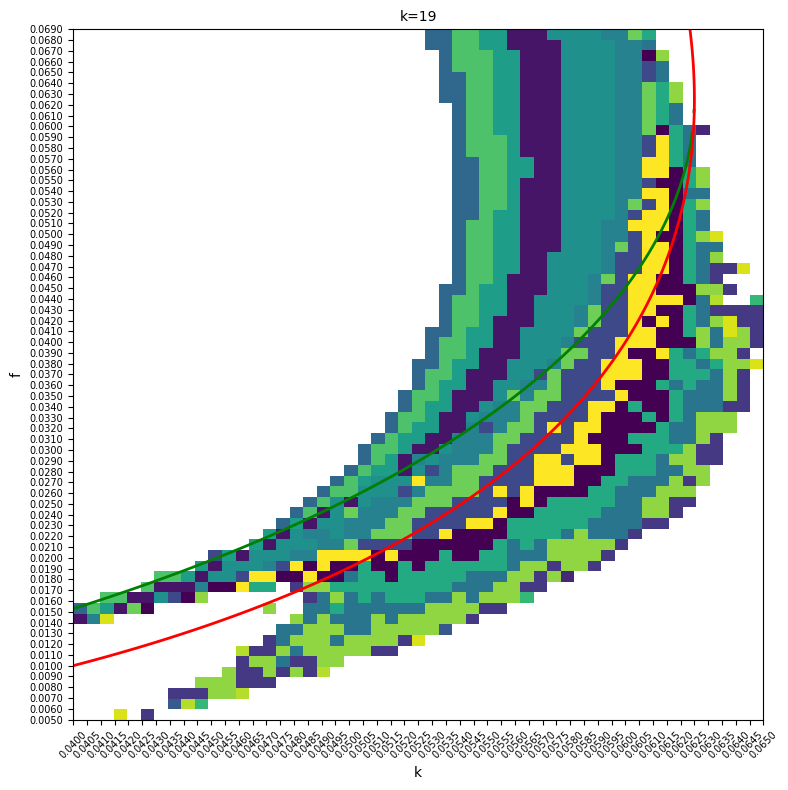

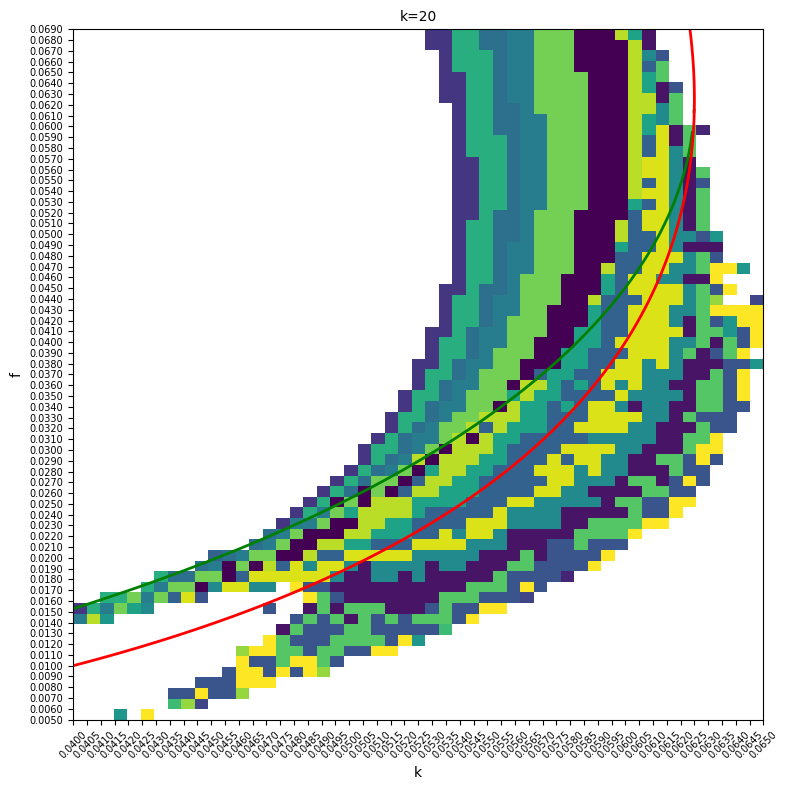

In [118]:
# k=2..20 のヒートマップを順に出力
for k in range(2, 21):
    plot_final_heatmap_for_k(k)

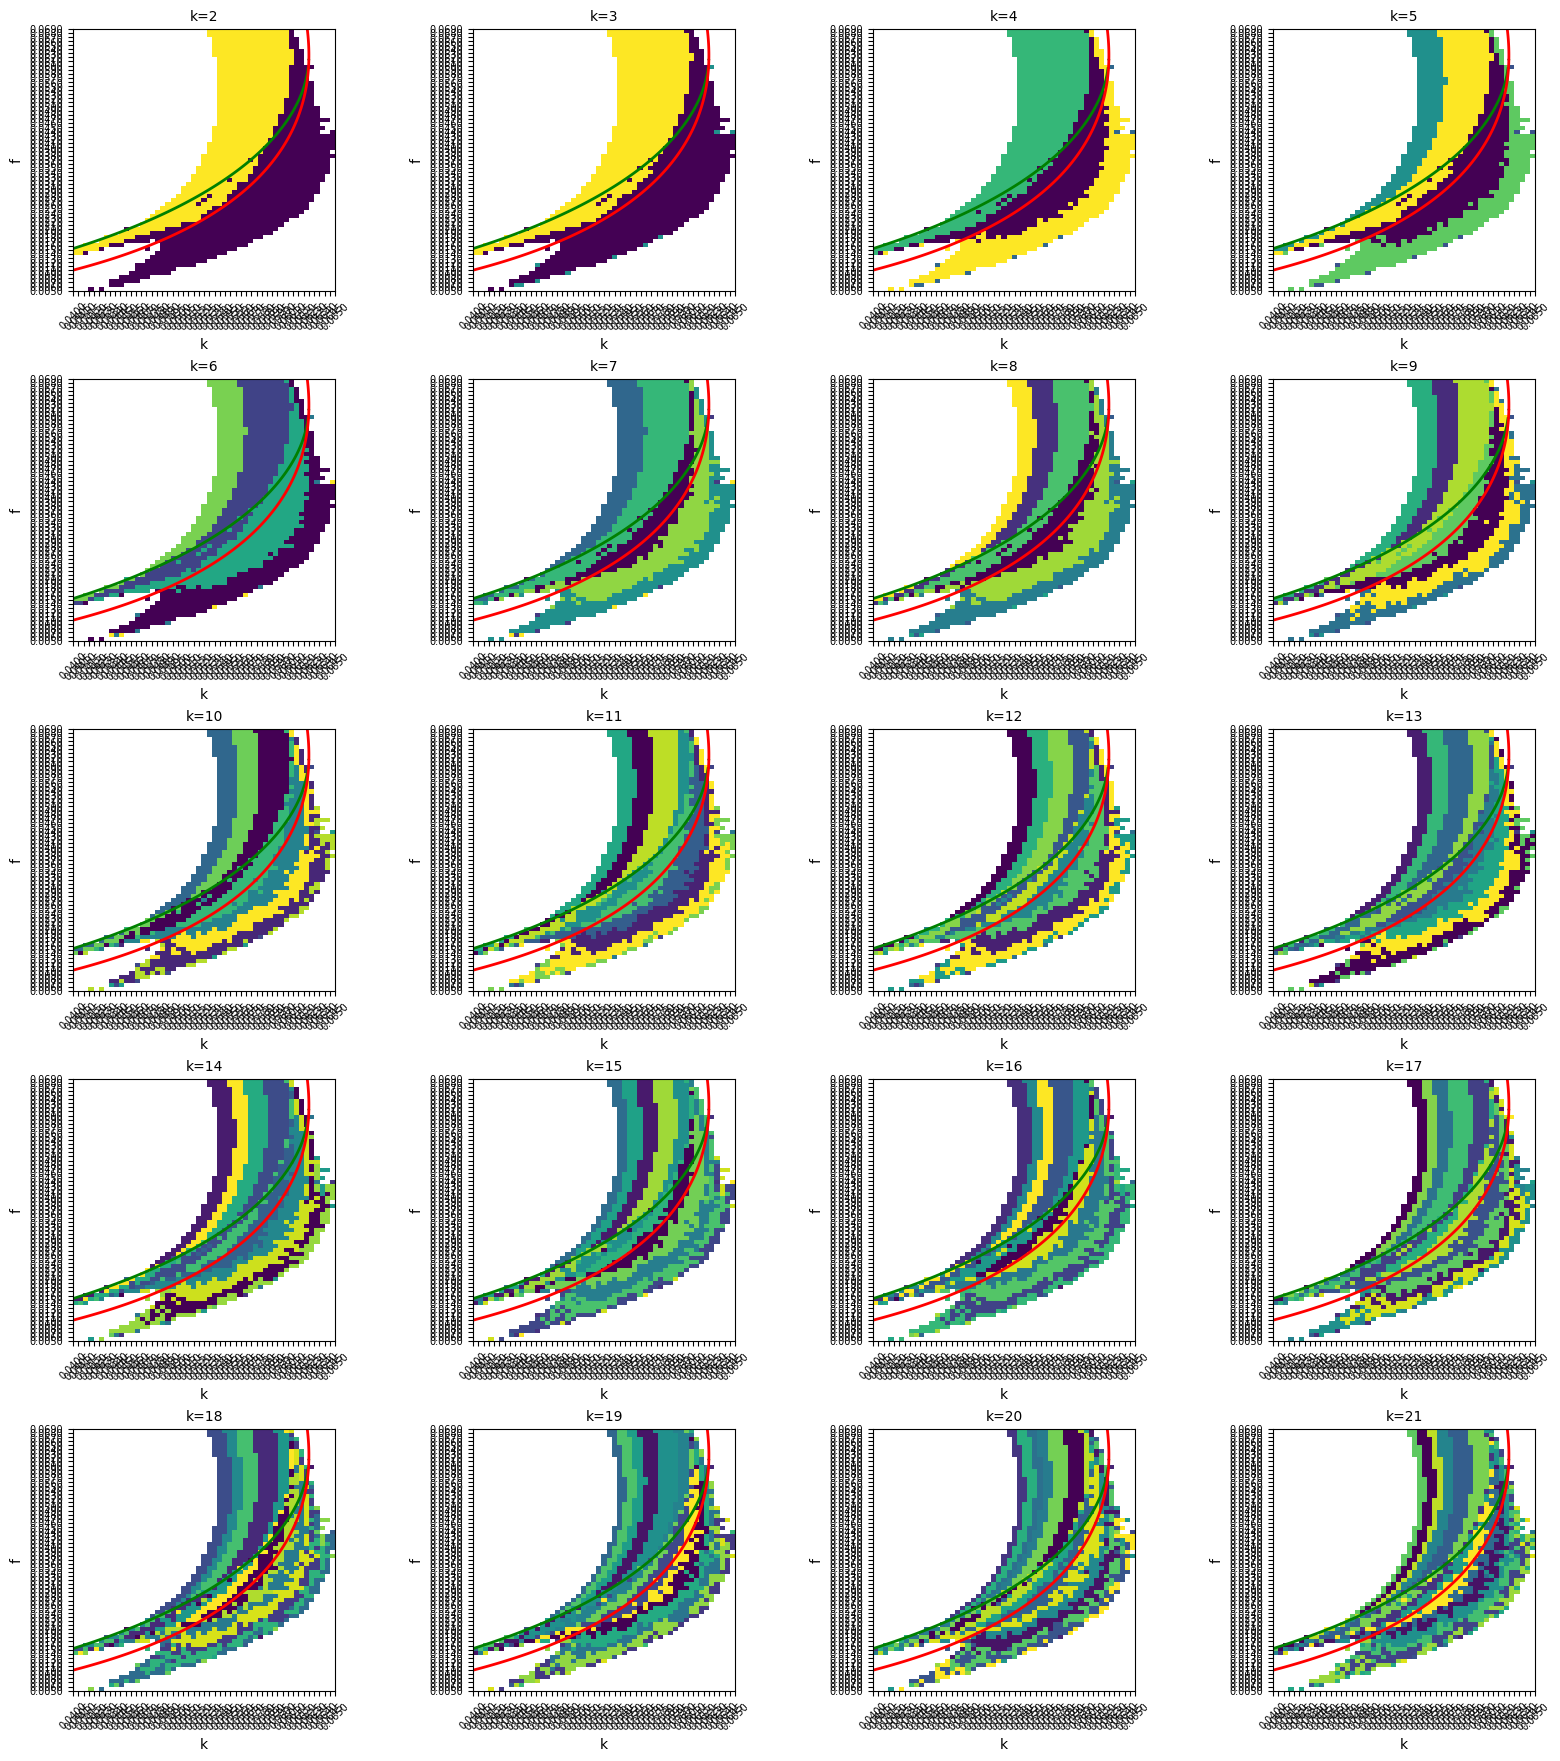

In [119]:
# k=2..21 を 5x4 グリッドで表示
ks = list(range(2, 22))
rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3.5), constrained_layout=True)
axes = axes.ravel()

for ax, k in zip(axes, ks):
    plot_final_heatmap_for_k(k, ax=ax)

# 余ったサブプロットは非表示
for j in range(len(ks), len(axes)):
    axes[j].axis('off')

plt.show()
